<a href="https://colab.research.google.com/github/ryo-k2mt/lodging-price-prediction/blob/preprocessing-v1/lodging_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目標：民泊サービスの物件データを使って、宿泊価格を予測するモデルの構築
# 背景：
近年、個人物件を貸し出す民泊サービスが流行っています。民泊では物件オーナーが、部屋の広さや立地をもとに宿泊価格を決めていますが、妥当な料金設定を行うのは容易ではありません。そこで今回は、民泊サービスであるAirbnbの掲載物件データを使って、宿泊価格を予測するモデルの構築にチャレンジしよう！

### データ概要
- 課題種別：回帰
- データ種別：多変量
- 学習データサンプル数：55583
- 説明変数の数：27
- 欠損値：有り

# google drive へマウント

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ライブラリのインポート

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# データの読み込み

In [67]:
train_data = pd.read_csv('/content/drive/MyDrive/competesion_data/lodging-price-prediction/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/competesion_data/lodging-price-prediction/test.csv')
train_copy = train_data.copy()
test_copy = test_data.copy()


In [68]:
list(train_data.columns)

['id',
 'accommodates',
 'amenities',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'description',
 'first_review',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_response_rate',
 'host_since',
 'instant_bookable',
 'last_review',
 'latitude',
 'longitude',
 'name',
 'neighbourhood',
 'number_of_reviews',
 'property_type',
 'review_scores_rating',
 'room_type',
 'thumbnail_url',
 'zipcode',
 'y']

# 前処理

### データの確認

In [69]:
train_data.head(1)

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,...,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0


In [70]:
train_data.head(1)

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,...,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0


In [71]:
len(train_data)

55583

In [72]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55583 entries, 0 to 55582
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      55583 non-null  int64  
 1   accommodates            55583 non-null  int64  
 2   amenities               55583 non-null  object 
 3   bathrooms               55436 non-null  float64
 4   bed_type                55583 non-null  object 
 5   bedrooms                55512 non-null  float64
 6   beds                    55487 non-null  float64
 7   cancellation_policy     55583 non-null  object 
 8   city                    55583 non-null  object 
 9   cleaning_fee            55583 non-null  object 
 10  description             55583 non-null  object 
 11  first_review            43675 non-null  object 
 12  host_has_profile_pic    55435 non-null  object 
 13  host_identity_verified  55435 non-null  object 
 14  host_response_rate      41879 non-null

固有名詞カラムや学習に影響を起こさないであろうカラムの削除

In [73]:
delete_columns = ['id', 'name', 'thumbnail_url', 'zipcode']
for delete_column in delete_columns:
  train_data = train_data.drop(delete_column, axis=1)
  test_data = test_data.drop(delete_column, axis=1)

### 欠損値処理

欠損値の確認

In [74]:
null_counts = train_data.isnull().sum()
null_counts

accommodates                  0
amenities                     0
bathrooms                   147
bed_type                      0
bedrooms                     71
beds                         96
cancellation_policy           0
city                          0
cleaning_fee                  0
description                   0
first_review              11908
host_has_profile_pic        148
host_identity_verified      148
host_response_rate        13704
host_since                  148
instant_bookable              0
last_review               11880
latitude                      0
longitude                     0
neighbourhood              5160
number_of_reviews             0
property_type                 0
review_scores_rating      12556
room_type                     0
y                             0
dtype: int64

In [75]:
print(type(null_counts))

<class 'pandas.core.series.Series'>


In [76]:
missing_value_columns = []
for key, value in train_data.isnull().sum().iteritems():
  if value > 0:
    missing_value_columns.append(key)
for column in missing_value_columns:
  target_feature = train_data[column]
  item_type = target_feature.dtype
  mode = target_feature.mode()[0]
  print(column, item_type, mode)
  if item_type == 'object':
    train_data[column] = train_data[column].fillna(mode)
    # target_feature.fillna('不明')
  else:
    mean = target_feature.mean()
    median = target_feature.median()
    train_data[column] = train_data[column].fillna(mean)
    # target_feature = target_feature.fillna(median)

bathrooms float64 1.0
bedrooms float64 1.0
beds float64 1.0
first_review object 2017-01-01
host_has_profile_pic object t
host_identity_verified object t
host_response_rate object 100%
host_since object 2015-03-30
last_review object 2017-04-30
neighbourhood object Williamsburg
review_scores_rating float64 100.0


<ipython-input-76-b6e8e4bda2ad>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in train_data.isnull().sum().iteritems():


In [77]:
# # 最頻値で欠損値を埋める
# for column in missing_value_columns:
#   if column == 'review_scores_rating':
#     continue
#   mode = train_data[column].mode()[0]
#   train_data[column] = train_data[column].fillna(mode)
#   test_data[column] = test_data[column].fillna(mode)

# # 平均値で欠損値を埋める
# mode = train_data['review_scores_rating'].mean()
# train_data['review_scores_rating'] = train_data['review_scores_rating'].fillna(mode)
# test_data['review_scores_rating'] = test_data['review_scores_rating'].fillna(mode)

In [78]:
null_counts = pd.DataFrame(train_data.isnull().sum())
null_counts

,0
accommodates,0
amenities,0
bathrooms,0
bed_type,0
bedrooms,0
beds,0
cancellation_policy,0
city,0
cleaning_fee,0
description,0


### 文字列要素のカラムの変換

- ammenities：
- bed_type：ラベル→ラベルエンコーディング
- cancellation_plicy：ラベル→ラベルエンコーディング
- city：ラベル→ラベルエンコーディング
- cleaning_fee：T/F→ラベルエンコーディング
- description：センテンス→TF-IDFベースのベクトル化
- first_reviw：日付→各項目でカラムを分け、数値化
- host_has_profile_pic：T/F→ラベルエンコーディング
- host_identity_verified：T/F→ラベルエンコーディング
- host_response_rate：パーセント→数値を抜き出しint化。空欄は0?-1?
- host_since：日付→各項目でカラムを分け、数値化
- instant_bookable：T/F→ラベルエンコーディング
- last_review：日付→各項目でカラムを分け、数値化
- name：賃貸名→固有名詞は一旦削除
- neighbourhood：名前？→固有名詞は一旦削除
- property_type：ラベル→ラベルエンコーディング
- room_type：ラベル→ラベルエンコーディング
- thumbnail_url：URL→削除
- zip_code：？数値ではある。（空欄あり）→

ラベルに対する処理

In [79]:

le = LabelEncoder()
encoding_labels = [
    'bed_type',
    'cancellation_policy',
    'city',
    'cleaning_fee',
    'host_has_profile_pic',
    'host_identity_verified',
    'instant_bookable',
    'property_type',
    'room_type',
    'neighbourhood'
]
for label in encoding_labels:
  new_column = f'Encoded_{label}'
  train_data[new_column] = le.fit_transform(train_data[label])
  train_data = train_data.drop(label, axis=1)
  test_data[new_column] = le.fit_transform(test_data[label])
  test_data = test_data.drop(label, axis=1)


train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55583 entries, 0 to 55582
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    55583 non-null  int64  
 1   amenities                       55583 non-null  object 
 2   bathrooms                       55583 non-null  float64
 3   bedrooms                        55583 non-null  float64
 4   beds                            55583 non-null  float64
 5   description                     55583 non-null  object 
 6   first_review                    55583 non-null  object 
 7   host_response_rate              55583 non-null  object 
 8   host_since                      55583 non-null  object 
 9   last_review                     55583 non-null  object 
 10  latitude                        55583 non-null  float64
 11  longitude                       55583 non-null  float64
 12  number_of_reviews               

日付データに対する処理

In [80]:
# 要素か年月日を取得する関数
def extract_YMD(df, target_column):
  # df[target_column] = df[target_column].fillna('0000-00-00')
  # year_column = f'{target_column}_year'
  # month_column = f'{target_column}_month'
  # day_column = f'{target_column}_day'
  # df[[year_column, month_column, day_column]] = df[target_column].str.split('-', expand=True).astype(int)
  df = df.drop(target_column, axis=1)
  return df

In [81]:
date_columns = [
    'first_review',
    'host_since',
    'last_review'
]
for column in date_columns:
  # 各要素は YYYY/MM/DD
  train_data = extract_YMD(train_data, column)
  test_data = extract_YMD(test_data, column)

amenities の処理

In [82]:
# amenities を　文字列からリストへ変換
amenities = []
for material in train_data['amenities']:
  for replace_str in ['{', '}', '"']:
    material = material.replace(replace_str, '')
  material = material.split(',')
  amenities.append(material)
train_data['amenities'] = amenities

In [83]:
# アメニティ列をexplodeして、各アメニティごとに行を作成
amenities_exploded = train_data['amenities'].explode()

# explodeしたデータを使ってワンホットエンコーディング
onehot_encoded = pd.get_dummies(amenities_exploded).groupby(level=0).sum()

# 元のデータフレームにワンホットエンコーディングしたデータを結合
train_data = pd.concat([train_data, onehot_encoded], axis=1)


In [84]:
train_data = train_data.drop('amenities', axis=1)

hosted_response_rate の処理

In [85]:
host_response_rate_mode = train_data['host_response_rate'].mode()[0]

# 最頻値で補完する
train_data['host_response_rate'] = train_data['host_response_rate'].fillna(host_response_rate_mode)
test_data['host_response_rate'] = test_data['host_response_rate'].fillna(host_response_rate_mode)

print(train_data['host_response_rate'].isnull().sum())

# 要素に % が含まれるので、削除し int 型へ変換する。
train_data['host_response_rate'] = train_data['host_response_rate'].str.replace('%', '').astype(int)
train_data['host_response_rate'].dtype
test_data['host_response_rate'] = test_data['host_response_rate'].str.replace('%', '').astype(int)


0


description の処理

In [86]:
## TFIFF を使用して文字列を変換したいが、 toarray 関数でセクションがクラッシュしてしまうので、description 列はとりあえず削除する方向で進める。
train_data = train_data.drop('description', axis=1)
test_data = test_data.drop('description', axis=1)
# tfidvectorizer = TfidfVectorizer()
# # train_data の変換
# train_tfid_matrix = tfidvectorizer.fit_transform(train_data['description'])
# train_data['description'] = train_tfid_matrix.toarray()
# # test_data の変換
# test_tfid_matrix = tfidvectorizer.transform(test_data['description'])
# test_data['description'] = test_tfid_matrix.toarray()

要素が文字列の列がないかの最終確認

In [87]:
object_columns = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
object_columns

[]

# 損失関数の定義
→ sickit learn を使用する場合はモデルに組み込まれているためいらない。

# データの分割

In [88]:
t = train_data['y'].astype(int)
train_data = train_data.drop('y', axis=1)

In [89]:
x_train, x_val, t_train, t_val = train_test_split(train_data, t, train_size=0.8, random_state=0)

# 正規化

In [90]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
# test_data = scaler.transform(test_data)

# 学習

In [91]:
#　モデルの選択
from sklearn.linear_model import SGDClassifier, LinearRegression, SGDRegressor

# model = SGDClassifier(loss='log_loss', random_state=0)
model = LinearRegression()
# model = SGDRegressor(max_iter=100, tol=1e-3, penalty=None, eta0=0.01, random_state=0)

In [92]:
# 学習実行
model.fit(x_train, t_train)

SGDRegressor(max_iter=100, penalty=None, random_state=0)

# 性能評価

In [93]:
train_score = model.score(x_train, t_train)
print(f"Train score: {train_score}")

Train score: -4.1957724258338703e+18


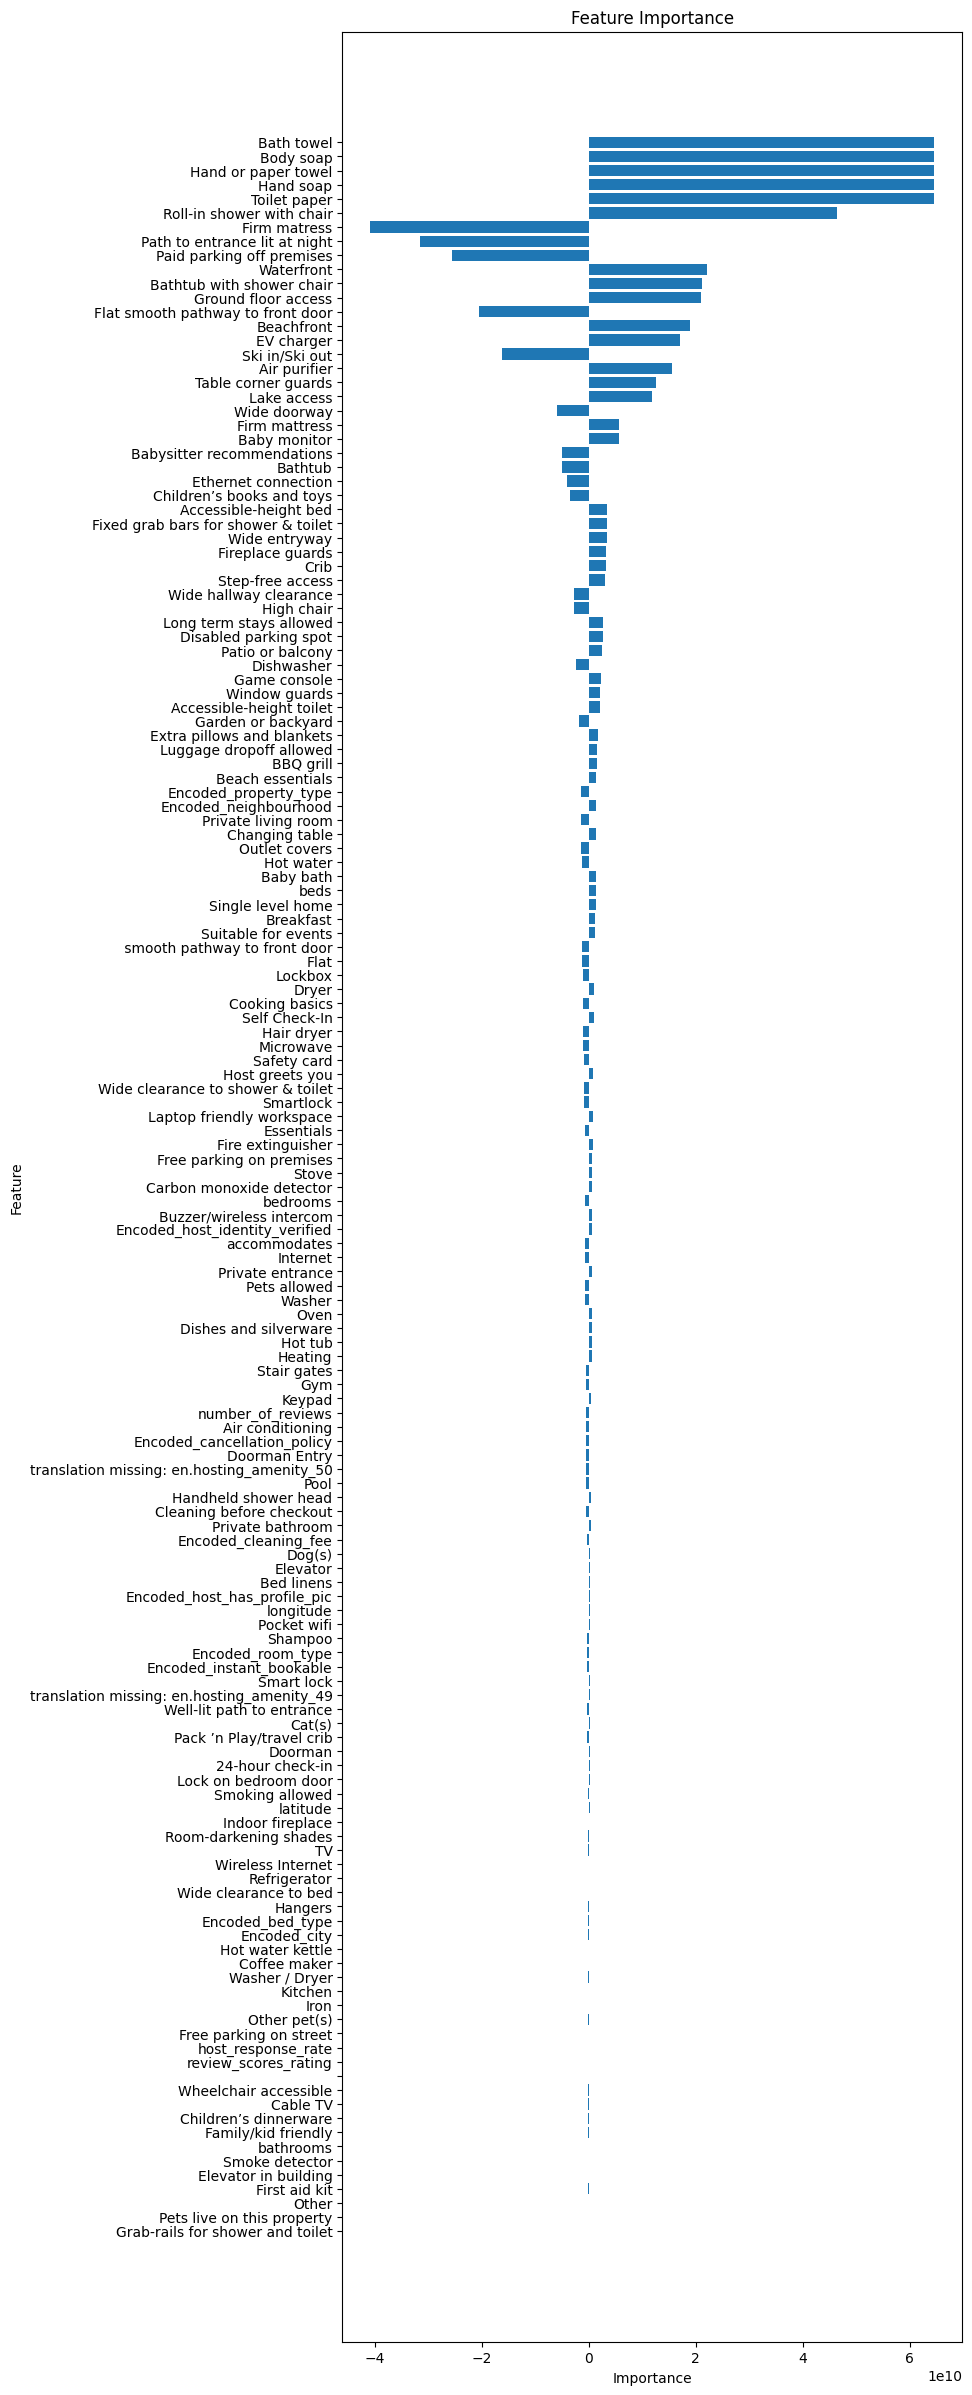

In [94]:
coef = model.coef_
columns = train_data.columns
features_importances = zip(columns, coef)
sorted_features = sorted(features_importances, key=lambda x: abs(x[1]), reverse=True)

# データの準備
labels, values = zip(*sorted_features)

plt.figure(figsize=(8, 30))
# 棒グラフのプロット
plt.barh(range(len(labels)), values, align='center')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # グラフを重要度の高い順に表示
plt.show()

# 推論

In [95]:
val_pred = model.predict(x_val)

In [96]:
from sklearn.metrics import r2_score

# 回帰モデルの評価
val_r2 = r2_score(t_val, val_pred)
print(f'Validation R^2:" {round(val_r2, 2)}')

Validation R^2:" -6.304701517727453e+17
